In [21]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt

def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

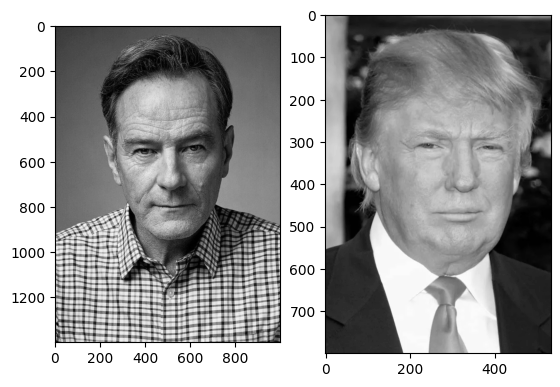

In [22]:
# define source and destination images.
src_img = cv2.imread('w.jpg')
dst_img = cv2.imread('jj.jpg')


src_img_gray = cv2.cvtColor(src_img,cv2.COLOR_BGR2GRAY)
dst_img_gray = cv2.cvtColor(dst_img,cv2.COLOR_BGR2GRAY)

# create mask from src image
src_mask = np.zeros_like(src_img_gray)
dst_mask = np.zeros_like(dst_img_gray)


plt.subplot(1,2,1)
plt.imshow(src_img_gray,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(dst_img_gray,cmap='gray')

In [23]:
# initialize face detector.
face_detector = dlib.get_frontal_face_detector()
# Load 68 facial points.
landmark_detector = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

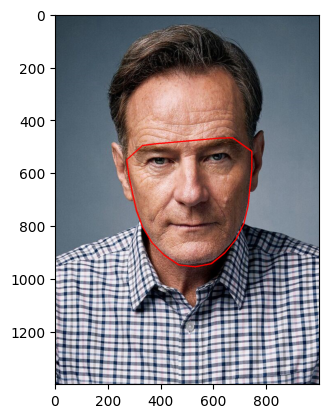

In [24]:
# Extract faces from source image using dlib
src_face_coordinates = face_detector(src_img_gray)[0]
# find src facial landmarks
src_landmarks = landmark_detector(src_img_gray,src_face_coordinates)
src_landmarks_points = [(p.x,p.y) for p in src_landmarks.parts()]


temp_img = cv2.cvtColor(src_img.copy(),cv2.COLOR_BGR2RGB)
# specify the face border using convex hull and facial landmarks of the source image.
convexhull = cv2.convexHull(np.array([src_landmarks_points],np.int32))
cv2.polylines(temp_img, [convexhull], True, (255, 0, 0), 3)
cv2.fillConvexPoly(src_mask, convexhull, 255)


plt.imshow(temp_img)

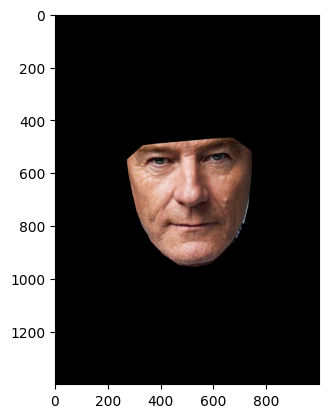

In [25]:
# Just showing the extracted face using convex hull
temp_img = cv2.cvtColor(src_img.copy(),cv2.COLOR_BGR2RGB)
src_img_face = cv2.bitwise_and(temp_img, temp_img, mask=src_mask)
plt.imshow(src_img_face)

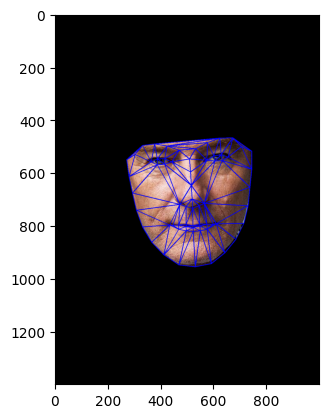

In [26]:
# Now we do the delunay trinagulation
rect = cv2.boundingRect(convexhull)
subdiv = cv2.Subdiv2D(rect)
subdiv.insert(src_landmarks_points)
triangles = subdiv.getTriangleList()
triangles = np.array(triangles, dtype=np.int32)

src_indexes_triangles = []
src_landmarks_points = np.array(src_landmarks_points)

for t in triangles:
    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])
    index_pt1 = np.where((src_landmarks_points == pt1).all(axis=1))
    index_pt1 = extract_index_nparray(index_pt1)
    index_pt2 = np.where((src_landmarks_points == pt2).all(axis=1))
    index_pt2 = extract_index_nparray(index_pt2)
    index_pt3 = np.where((src_landmarks_points == pt3).all(axis=1))
    index_pt3 = extract_index_nparray(index_pt3)
    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
        triangle = [index_pt1, index_pt2, index_pt3]
        src_indexes_triangles.append(triangle)
        
    cv2.line(src_img_face, pt1, pt2, (0, 0, 255), 2)
    cv2.line(src_img_face, pt2, pt3, (0, 0, 255), 2)
    cv2.line(src_img_face, pt1, pt3, (0, 0, 255), 2)
plt.imshow(src_img_face)


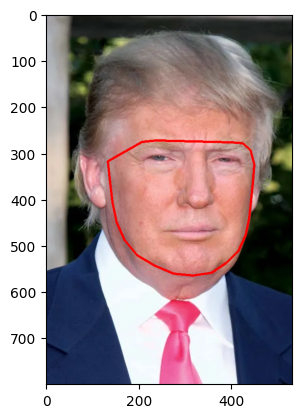

In [27]:
# Extract faces from source image using dlib
dst_face_coordinates = face_detector(dst_img_gray)[0]
# find src facial landmarks
dst_landmarks = landmark_detector(dst_img_gray,dst_face_coordinates)
dst_landmarks_points = [(p.x,p.y) for p in dst_landmarks.parts()]


temp_img = cv2.cvtColor(dst_img.copy(),cv2.COLOR_BGR2RGB)
# specify the face border using convex hull and facial landmarks of the source image.
convexhull = cv2.convexHull(np.array([dst_landmarks_points],np.int32))
cv2.polylines(temp_img, [convexhull], True, (255, 0, 0), 3)
cv2.fillConvexPoly(dst_mask, convexhull, 255)

plt.imshow(temp_img)

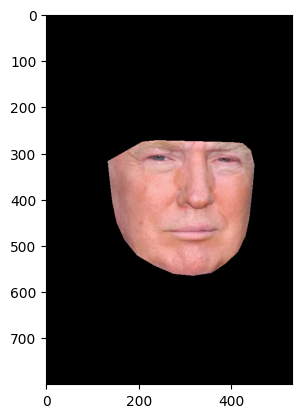

In [28]:
#Extract the dst face just to apply and show triangulation
# Just showing the extracted face by applying mask.
temp_img = cv2.cvtColor(dst_img.copy(),cv2.COLOR_BGR2RGB)
dst_face_img = cv2.bitwise_and(temp_img, temp_img, mask = dst_mask)
plt.imshow(dst_face_img)

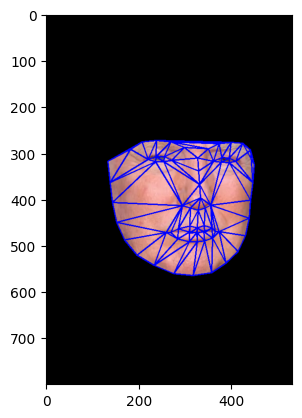

In [29]:
# Delanut trinagluation of the second face based on the src triangulation
for triangle_index in src_indexes_triangles:
    pt1 = dst_landmarks_points[triangle_index[0]]
    pt2 = dst_landmarks_points[triangle_index[1]]
    pt3 = dst_landmarks_points[triangle_index[2]]

    cv2.line(dst_face_img, pt1, pt2, (0, 0, 255), 2)
    cv2.line(dst_face_img, pt2, pt3, (0, 0, 255), 2)
    cv2.line(dst_face_img, pt1, pt3, (0, 0, 255), 2)
plt.imshow(dst_face_img)

In [30]:
dst_new_face = np.zeros(dst_img.shape, np.uint8)
# Now we will do the wrap triangulation
for triangle_index in src_indexes_triangles:
    src_tri_pt1 = src_landmarks_points[triangle_index[0]]
    src_tri_pt2 = src_landmarks_points[triangle_index[1]]
    src_tri_pt3 = src_landmarks_points[triangle_index[2]]
    src_triangle = np.array([src_tri_pt1, src_tri_pt2, src_tri_pt3], np.int32)
    src_rect = cv2.boundingRect(src_triangle)
    (x, y, w, h) = src_rect
    cropped_src_triangle = src_img[y: y + h, x: x + w]
    cropped_src_mask = np.zeros((h, w), np.uint8)
    src_points = np.array([[src_tri_pt1[0] - x, src_tri_pt1[1] - y],
                      [src_tri_pt2[0] - x, src_tri_pt2[1] - y],
                      [src_tri_pt3[0] - x, src_tri_pt3[1] - y]], np.int32)
    
    cv2.fillConvexPoly(cropped_src_mask, src_points, 255)
    cropped_src_triangle = cv2.bitwise_and(cropped_src_triangle, cropped_src_triangle,
                                       mask=cropped_src_mask)
    

    dst_tri_pt1 = dst_landmarks_points[triangle_index[0]]
    dst_tri_pt2 = dst_landmarks_points[triangle_index[1]]
    dst_tri_pt3 = dst_landmarks_points[triangle_index[2]]
    dst_triangle = np.array([dst_tri_pt1, dst_tri_pt2, dst_tri_pt3], np.int32)
    dst_rect = cv2.boundingRect(dst_triangle)
    (x, y, w, h) = dst_rect
    cropped_dst_triangle = dst_img[y: y + h, x: x + w]
    cropped_dst_mask = np.zeros((h, w), np.uint8)
    dst_points = np.array([[dst_tri_pt1[0] - x, dst_tri_pt1[1] - y],
                       [dst_tri_pt2[0] - x, dst_tri_pt2[1] - y],
                       [dst_tri_pt3[0] - x, dst_tri_pt3[1] - y]], np.int32)
    cv2.fillConvexPoly(cropped_dst_mask, dst_points, 255)
    cropped_dst_triangle = cv2.bitwise_and(cropped_dst_triangle, cropped_dst_triangle,
                                       mask=cropped_dst_mask)
    
    src_points = np.float32(src_points)
    dst_points = np.float32(dst_points)
    # find affine matrix and apply it on croppeped triangle.
    M = cv2.getAffineTransform(src_points, dst_points)
    warped_triangle = cv2.warpAffine(cropped_src_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_dst_mask)

    
    dst_new_face_rect_area = dst_new_face[y: y + h, x: x + w]
    dst_new_face_rect_area_gray = cv2.cvtColor(dst_new_face_rect_area, cv2.COLOR_BGR2GRAY)

    # Let's create a mask to remove the lines between the triangles
    _,mask_triangles_designed = cv2.threshold(dst_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    # Reconstruct new image by adding triangles.
    dst_new_face_rect_area = cv2.add(dst_new_face_rect_area, warped_triangle)
    dst_new_face[y: y + h, x: x + w] = dst_new_face_rect_area


# remove the dst face from dst image using convex hull of dst image founded by facial landmarks, earlier.
dst_face_mask = np.zeros_like(dst_img_gray)
dst_head_mask = cv2.fillConvexPoly(dst_face_mask, convexhull, 255)
dst_face_mask = cv2.bitwise_not(dst_head_mask)
dst_head_noface = cv2.bitwise_and(dst_img, dst_img, mask=dst_face_mask)


result = cv2.add(dst_head_noface, dst_new_face)

# apply seamless cloning to fix the color
(x, y, w, h) = cv2.boundingRect(convexhull)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone = cv2.seamlessClone(result, dst_img, dst_head_mask, center_face2, cv2.MIXED_CLONE)

# apply median filter to remove the noise.
seamlessclone = cv2.medianBlur(seamlessclone,3)

# Naming a window
cv2.namedWindow("Resized_Window", cv2.WINDOW_NORMAL)
  
# Using resizeWindow()
cv2.resizeWindow("Resized_Window", 700, 700)
cv2.imshow("Resized_Window",seamlessclone)

cv2.imwrite('facewap.jpg',seamlessclone)
while True:
    k = cv2.waitKey(0) & 0xFF
    print(k)
    if k == 27:
        cv2.destroyAllWindows()
        break


27
